#Experiment 8: Adversarial Debiasing (AIF360)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This Colab-ready notebook trains an Adversarial Debiasing model from AIF360 (requires TensorFlow 1.x), evaluates fairness, and produces SHAP DeepExplainer explanations.

## Step 0: Install Dependencies

In [ ]:
!pip install aif360 tensorflow shap pandas matplotlib seaborn scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.2 MB/s eta 0:00:00


In [ ]:
pip install tensorflow==1.15 aif360 shap pandas scikit-learn matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow==1.15 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==1.15


## Step 1: Load and Preprocess LendingClub Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from aif360.datasets import StandardDataset

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

# Select relevant columns
selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

# Binary target conversion
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categorical features
for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Standardize numeric columns
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])


/tmp/ipython-input-260253378.py:7: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')


## Step 2: Create AIF360 Dataset

In [ ]:
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

## Step 3: Train Adversarial Debiasing Model

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from aif360.algorithms.inprocessing import AdversarialDebiasing

sess = tf.Session()

adversary = AdversarialDebiasing(privileged_groups=privileged_groups,
                                 unprivileged_groups=unprivileged_groups,
                                 scope_name='adv_debiasing',
                                 debias=True,
                                 sess=sess)

adversary.fit(aif_data)
preds = adversary.predict(aif_data)

Instructions for updating:
non-resource variables are not supported in the long term
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 11.845063; batch adversarial loss: 258.833496
epoch 1; iter: 0; batch classifier loss: 16.420574; batch adversarial loss: 152.015335
epoch 2; iter: 0; batch classifier loss: 11.212827; batch adversarial loss: 147.975372
epoch 3; iter: 0; batch classifier loss: 6.408032; batch adversarial loss: 107.643082
epoch 4; iter: 0; batch classifier loss: 9.345661; batch adversarial loss: 73.235199
epoch 5; iter: 0; batch classifier loss: 3.724158; batch adversarial loss: 38.163910
epoch 6; iter: 0; batch classifier loss: 3.755505; batch adversarial loss: -31.429008
epoch 7; iter: 0; batch classifier loss: 3.896621; batch adversarial loss: -61.186775
epoch 8; iter: 0; batch classifier loss: 3.529760; batch adversarial loss: -137.801575
epoch 9; iter: 0; batch classifier loss: 5.195357; batch adversarial loss: -123.446388
epoch 10; iter: 0; batch classifier loss: 9.525496; batch adversarial loss: -159.805328
epoch 11; iter: 0; batch classifier loss: 6.45608

## Step 4: Evaluate Performance and Fairness

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from aif360.metrics import ClassificationMetric

y_true = aif_data.labels.ravel()
y_pred = preds.labels.ravel()
y_prob = preds.scores.ravel()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("AUC-ROC:", roc_auc_score(y_true, y_prob))

metric = ClassificationMetric(aif_data, preds,
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())
print("Equal Opportunity Difference:", metric.equal_opportunity_difference())
print("Average Odds Difference:", metric.average_odds_difference())
print("Bias Amplification:", metric.between_group_generalized_entropy_index())
print("Theil Index:", metric.theil_index())

Accuracy: 0.2768
Precision: 0.9565217391304348
Recall: 0.006048941435248831
F1 Score: 0.012021857923497269
AUC-ROC: 0.7298813591700688
Statistical Parity Difference: -0.15384615384615385
Disparate Impact: 0.8461538461538461
Equal Opportunity Difference: -0.08333333333333337
Average Odds Difference: -0.5416666666666667
Bias Amplification: 172.57692307692307
Theil Index: 1.2840162240481492


## Step 5: SHAP DeepExplainer

  0%|          | 0/50 [00:00<?, ?it/s]

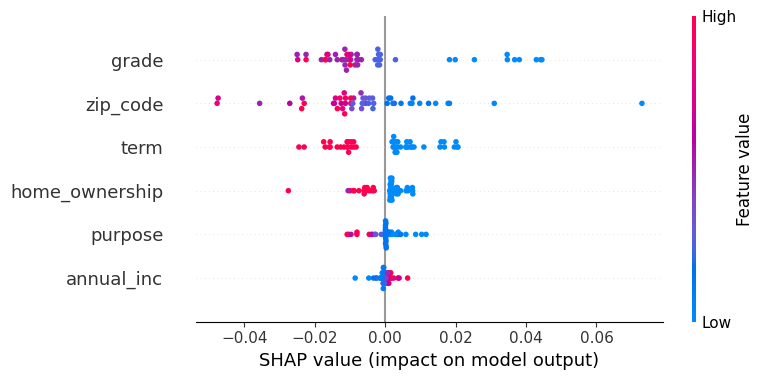

In [ ]:
import pandas as pd
import numpy as np
import shap
from aif360.datasets import StandardDataset

# --- create a small subset to use as background / evaluation for SHAP ---
# use at most 100 rows but keep background small for KernelExplainer performance
max_rows = 100
subset = aif_data.copy()
n_rows = min(max_rows, subset.features.shape[0])
subset.features = subset.features[:n_rows]
subset.labels = subset.labels[:n_rows]
subset.protected_attributes = subset.protected_attributes[:n_rows]

X_df = pd.DataFrame(subset.features, columns=subset.feature_names)

# --- safe model wrapper for adversary.predict used by SHAP ---
def model_fn(x_numpy):
    """
    x_numpy: numpy array of shape (m, n_features)
    Returns: 1D numpy array of scores length m
    This constructs a small AIF360 StandardDataset for the given rows so adversary.predict
    can index labels and protected_attributes without error.
    """
    # Build DataFrame with the same feature columns
    tmp_df = pd.DataFrame(x_numpy, columns=subset.feature_names)

    # Add a dummy label column required by StandardDataset creation.
    # Value does not matter for prediction, but StandardDataset needs it.
    tmp_df['loan_status'] = 0

    # Create a StandardDataset. Ensure the protected attribute is present as a column.
    # If your protected attribute name differs, replace 'zip_code' accordingly.
    ds = StandardDataset(tmp_df,
                         label_name='loan_status',
                         favorable_classes=[1],
                         protected_attribute_names=['zip_code'],
                         privileged_classes=[[1]])

    # Predict using adversary and return scores as 1D array
    preds_ds = adversary.predict(ds)
    return preds_ds.scores.ravel()

# --- KernelExplainer setup: use a small background to reduce cost ---
# Use 20 rows for background if available
background = X_df.values[:20] if X_df.shape[0] > 20 else X_df.values

explainer = shap.KernelExplainer(model_fn, background)

# Evaluate SHAP on a small subset only. KernelExplainer is expensive.
eval_n = 50 if X_df.shape[0] >= 50 else X_df.shape[0]
eval_data = X_df.values[:eval_n]

# nsamples controls runtime / variance. Increase only if you can afford the time.
shap_values = explainer.shap_values(eval_data, nsamples=200)

# shap_values may be a list (for multi-output). Handle common cases for plotting.
try:
    if isinstance(shap_values, list):
        # if multiple outputs, pick the main output (usually index 0)
        sv = shap_values[0]
    else:
        sv = shap_values

    shap.summary_plot(sv, pd.DataFrame(eval_data, columns=subset.feature_names))
except Exception as e:
    print("Error plotting SHAP summary:", e)


## Step 6: Save Results

In [ ]:
results = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred),
    'Recall': recall_score(y_true, y_pred),
    'F1': f1_score(y_true, y_pred),
    'AUC': roc_auc_score(y_true, y_prob),
    'SPD': metric.statistical_parity_difference(),
    'DI': metric.disparate_impact(),
    'EOD': metric.equal_opportunity_difference(),
    'AOD': metric.average_odds_difference(),
    'BiasAmp': metric.between_group_generalized_entropy_index(),
    'Theil': metric.theil_index()
}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/Research_Thesis_Implementation/exp8_adv_debiasing_results.csv', index=False)
print("Results saved successfully!")

Results saved successfully!
